# Sentiment Analysis of Yelp Reviews

Resources:
- [Introduction to Spark ML: An application to Sentiment Analysis
 ](http://classes.ischool.syr.edu/ist718/content/unit09/lab-sentiment_analysis/) : SparkML sentiment analysis lab from Syracruse University's IST718 Advanced Information Analytics course.
- [PySpark Docs](http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark-sql-module) 
---

## Setup

In [1]:
from pyspark.sql import SQLContext

import pyspark.sql.functions as F
from pyspark.mllib.stat import Statistics as stats

import requests

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Data Cleaning and Preparation

In [2]:
datapath = "data/yelp_dataset/review.json"

In [3]:
sqlContext = SQLContext(sc)

In [4]:
yelp_review_df = sqlContext.read.json(datapath)

In [5]:
yelp_review_df.show(5)

+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|      date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|uYHaNptLzDLoV_JZ_...|   0|2016-07-12|    0|VfBHSwC5Vz_pbFluy...|    5|My girlfriend and...|     0|cjpdDjZyprfyDG3Rl...|
|uYHaNptLzDLoV_JZ_...|   0|2016-10-02|    0|3zRpneRKDsOPq92tq...|    3|If you need an in...|     0|bjTcT8Ty4cJZhEOEo...|
|uYHaNptLzDLoV_JZ_...|   0|2015-09-17|    0|ne5WhI1jUFOcRn-b-...|    3|Mittlerweile gibt...|     0|AXgRULmWcME7J6Ix3...|
|uYHaNptLzDLoV_JZ_...|   0|2016-08-21|    0|llmdwOgDReucVoWEr...|    4|Location is every...|     0|oU2SSOmsp_A8JYI7Z...|
|uYHaNptLzDLoV_JZ_...|   0|2013-11-20|    0|DuffS87NaSMDmIflu...|    5|gute lage im stad...|     0|0xtbPEna2Kei11vsU...|
+--------------------+----+-----

In [6]:
# yelp_review_df.count()

4736897

In [6]:
yelp_review_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



### Add "Score" column for Validation
- **1** (positive sentiment) if stars > 3
- **-1** (negative sentiment) if stars < 3
- **0** (neutral) if stars == 3

In [7]:
from pyspark.sql import functions as F

yelp_review_df = yelp_review_df.withColumn("score",
    F.when(yelp_review_df["stars"] > 3, 1).\
    otherwise(0)
)

## Above is equivalent to.... 
# if yelp_review > 3: 
#     return 1
# else: 
#     return 0

In [8]:
yelp_review_df.select("review_id", "stars", "score").show(5)

+--------------------+-----+-----+
|           review_id|stars|score|
+--------------------+-----+-----+
|VfBHSwC5Vz_pbFluy...|    5|    1|
|3zRpneRKDsOPq92tq...|    3|    0|
|ne5WhI1jUFOcRn-b-...|    3|    0|
|llmdwOgDReucVoWEr...|    4|    1|
|DuffS87NaSMDmIflu...|    5|    1|
+--------------------+-----+-----+
only showing top 5 rows



### Random Split into Train, Validate, and Test Sets

In [9]:
train_df, valid_df, test_df = yelp_review_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [10]:
[train_df.count(), valid_df.count(), test_df.count()]

[2842323, 1420849, 473725]

---

# ANALYSIS

Building a Model for Sentiment Analysis: 
1. Tokenize Review text
2. Score/Reweight words so that common words (i.e. the, a) are weighted less. For this, we can use a Term Frequency -Inverse Document Frequency Pipeline, which is supported by Spark. 
    - [IDF](https://spark.apache.org/docs/2.2.0/ml-features.html#tf-idf)
    - Shortcut: Use external resource that has already identified 'stop words' (aka common words) from other corpora
3. Append Logistic Regression and Regularization to Pipeline.
4. Tune parameters for Model Regularization. 
5. Test Model.

## 1. Create Tokenizer for Review Text
- **setGaps:** False -> continue until no more words can be extracted
- **regex pattern:** "\\p{L}+" -> extract words without accent notation
- **name of input column:** text
- **name of output column:** words

In [11]:
from pyspark.ml.feature import RegexTokenizer

tokenizer = RegexTokenizer()\
    .setGaps(False)\
    .setPattern("\\p{L}+")\
    .setInputCol("text")\
    .setOutputCol("words")

In [13]:
review_words_df = tokenizer.transform(yelp_review_df)

In [14]:
review_words_df.select("review_id", "text", "words").show(5)

+--------------------+--------------------+--------------------+
|           review_id|                text|               words|
+--------------------+--------------------+--------------------+
|VfBHSwC5Vz_pbFluy...|My girlfriend and...|[my, girlfriend, ...|
|3zRpneRKDsOPq92tq...|If you need an in...|[if, you, need, a...|
|ne5WhI1jUFOcRn-b-...|Mittlerweile gibt...|[mittlerweile, gi...|
|llmdwOgDReucVoWEr...|Location is every...|[location, is, ev...|
|DuffS87NaSMDmIflu...|gute lage im stad...|[gute, lage, im, ...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



## 2 . Reweight words according to Term Frequency - Inverse Document Frequency (TF-IDF)
a.) **Stop-Word Filter:** filters out common words (i.e. the, that, a)

b.) **Count Vectorizer:** collects word/term frequency

c.) **IDF**: reweight words based on term frequency; assigns lower weight to high frequency terms and vice versa

d.) **COMBINE**: Create pipeline of TOKENIZER, STOP-WORD FILTER, COUNT VECTORIZER, IDF

### a.) Stop-Word Filter

Get list of stop words

In [12]:
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

Create a filter that removes stop words in list.

In [13]:
from pyspark.ml.feature import StopWordsRemover
sw_filter = StopWordsRemover()\
    .setStopWords(stop_words)\
    .setCaseSensitive(False)\
    .setInputCol("words")\
    .setOutputCol("filtered")

### b.) Count Vectorizer

Collect term frequency and store as a CountVectorizer
- **minTF (min term frequency):** word appears at least once in corpus
- **minDF (min doc frequency):** word appears in at least 5 docs (observations)
- **name of input column:** "filtered" = observations w/out stop words
- **name of output column:** "tf" = term frequency

In [14]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

#### Create pipeline of tokenizer, stop-word filter, and term-frequency vectorizer. 

This pipleline tokenizes review text, filters out stop words, and creates a column of frequency for each term.

In [15]:
from pyspark.ml import Pipeline
cv_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv])

In [ ]:
# cv_pipeline.fit(yelp_review_df)

In [19]:
# tf_df = cv_pipeline.transform(yelp_review_df)
# tf_df.select("review_id", "text", "words", "tf").show(5)

+--------------------+--------------------+--------------------+--------------------+
|           review_id|                text|               words|                  tf|
+--------------------+--------------------+--------------------+--------------------+
|VfBHSwC5Vz_pbFluy...|My girlfriend and...|[my, girlfriend, ...|(131072,[8,13,21,...|
|3zRpneRKDsOPq92tq...|If you need an in...|[if, you, need, a...|(131072,[0,2,3,4,...|
|ne5WhI1jUFOcRn-b-...|Mittlerweile gibt...|[mittlerweile, gi...|(131072,[1,15,140...|
|llmdwOgDReucVoWEr...|Location is every...|[location, is, ev...|(131072,[0,1,2,7,...|
|DuffS87NaSMDmIflu...|gute lage im stad...|[gute, lage, im, ...|(131072,[140,343,...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



### c.) IDF

Assign lower weight to common (high frequency) words using Spark's IDF (Inverse Document Frequency)function

In [16]:
from pyspark.ml.feature import IDF
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

### d.) Combine into pipeline

In [17]:
idf_pipeline = Pipeline(stages=[cv_pipeline, idf])

In [ ]:
# idf_pipeline.fit(yelp_review_df)

In [22]:
# tfidf_df = idf_pipeline.transform(yelp_review_df)
# tfidf_df.select("review_id", "text", "words", "tf", "tfidf").show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|           review_id|                text|               words|                  tf|               tfidf|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|VfBHSwC5Vz_pbFluy...|My girlfriend and...|[my, girlfriend, ...|(131072,[8,13,21,...|(131072,[8,13,21,...|
|3zRpneRKDsOPq92tq...|If you need an in...|[if, you, need, a...|(131072,[0,2,3,4,...|(131072,[0,2,3,4,...|
|ne5WhI1jUFOcRn-b-...|Mittlerweile gibt...|[mittlerweile, gi...|(131072,[1,15,140...|(131072,[1,15,140...|
|llmdwOgDReucVoWEr...|Location is every...|[location, is, ev...|(131072,[0,1,2,7,...|(131072,[0,1,2,7,...|
|DuffS87NaSMDmIflu...|gute lage im stad...|[gute, lage, im, ...|(131072,[140,343,...|(131072,[140,343,...|
+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



## 3. Append Logistic Regression and Regularization to Pipeline. 

In [18]:
from pyspark.ml.classification import LogisticRegression

lambda_par = 0.02
alpha_par = 0.3
en_lr = LogisticRegression().\
        setLabelCol('score').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

Try Pipeline w/ Logistic Regression and Elastic Net Regularization

In [19]:
en_lr_pipeline = Pipeline(stages=[idf_pipeline, en_lr])

In [ ]:
en_lr_pipeline.fit(train_df)

Display Accuracy:

In [25]:
en_lr_pipeline.transform(valid_df).select(F.avg(F.expr('float(prediction = score)'))).show()

+--------------------------------+
|avg(float((prediction = score)))|
+--------------------------------+
|              0.8492190232741129|
+--------------------------------+



**Model Accuracy:** 84.9%

**Given:**
- 0.02 regularization param
- 0.3 elastic net param

Evaluate model performance by looking at how the model classified positive and negative words.

First, gather the weights for each **word**.

In [26]:
vocabulary = idf_pipeline.stages[0].stages[-1].vocabulary
weights = en_lr_pipeline.stages[-1].coefficients.toArray()
weights_df = pd.DataFrame({'word': vocabulary, 'weight': weights})

Then, sort by weight (highest indicates positive sentiment, lowest for negative sentiment).

In [27]:
weights_df.sort_values('weight', ascending=False, inplace=True)

Display the words with top positive sentiment: 

In [28]:
weights_df.head(5)

,weight,word
5,0.418197,great
37,0.329732,amazing
38,0.302147,delicious
16,0.272759,best
83,0.252961,awesome


Display the words with top negative sentiment:

In [29]:
weights_df.tail(5)

,weight,word
422,-0.261137,terrible
349,-0.269260,rude
770,-0.272767,mediocre
390,-0.289224,horrible
358,-0.360243,worst


### What percentage of the words were classified as neutral? 

In [30]:
weights_df.query('weight == 0.0').shape[0]/weights_df.shape[0]

0.99737548828125

**99% of words classified as neutral**

## 4. Tune Model Regularization parameters. 

Tune lambda_par for regularization parameter and alpha_par for elastic-net parameter using PySpark's ParamGridBuilder

**Regularization Parameters to test:** 0, 0.01, 0.02

**Elastic Net Parameters to test:** 0, 0.2, 0.4


In [18]:
from pyspark.ml.tuning import ParamGridBuilder

en_lr_estimator = Pipeline(stages=[idf_pipeline, en_lr])

In [19]:
grid = ParamGridBuilder().\
    addGrid(en_lr.regParam, [0., 0.01, 0.02]).\
    addGrid(en_lr.elasticNetParam, [0., 0.2, 0.4]).\
    build()

Testing all combinations will produce **9 fitted models**. 

In [20]:
all_models = []
for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = en_lr_estimator.fit(train_df, grid[j])
    all_models.append(model)

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9


Collect accuracy for each of the fitted models

In [23]:
accuracies = [m.transform(valid_df).\
                select(F.avg(F.expr('float(score = prediction)')).alias('Accuracy')).\
                first().Accuracy 
              for m in all_models]

Use numpy to select best model

In [24]:
best_model_idx = np.argmax(accuracies)
best_model = all_models[best_model_idx]

Display best_model parameters:

In [26]:
grid[best_model_idx]

{Param(parent='LogisticRegression_45429809918e95f0a1a1', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
 Param(parent='LogisticRegression_45429809918e95f0a1a1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}

**BEST MODEL PARAMS:**
- regularization: 0.01
- ElasticNet: 0.0

Display Accuracy of best_model:

In [30]:
accuracies[best_model_idx]

0.8898348804130488

**88.98% Accuracy** when tested on **Validation data**

## 5. Test Best Model

In [27]:
results_best = best_model.transform(test_df)

In [31]:
results_best.select(F.avg(F.expr('float(prediction = score)'))).alias("Accuracy").show()

+--------------------------------+
|avg(float((prediction = score)))|
+--------------------------------+
|              0.8902168979893398|
+--------------------------------+



**89.02% Accuracy** on Test data

---

**The Spark kernel shut down when trying to perform operations after this. :(** 

So, I simply reran the model with the tuned parameteres to perform further analysis. 

In [20]:
lambda_par = 0.01
alpha_par = 0.0
en_lr = LogisticRegression().\
        setLabelCol('score').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

In [21]:
en_lr_pipeline = Pipeline(stages=[idf_pipeline, en_lr]).fit(train_df)

In [22]:
en_lr_pipeline.transform(valid_df).select(F.avg(F.expr('float(prediction = score)'))).show()

+--------------------------------+
|avg(float((prediction = score)))|
+--------------------------------+
|              0.8898348804130488|
+--------------------------------+



In [23]:
results_best = en_lr_pipeline.transform(test_df)

In [24]:
results_best.select(F.avg(F.expr('float(prediction = score)'))).show()

+--------------------------------+
|avg(float((prediction = score)))|
+--------------------------------+
|              0.8902168979893398|
+--------------------------------+



Extract Actual Totals for Positive and Negative Reviews

In [69]:
pos_total = test_df.where(test_df.stars > 3).count()
neg_total = test_df.where(test_df.stars < 4).count()

Extract true positve, false positive, true negative, and false negative counts. 

In [28]:
tp = results_best.filter((results_best.prediction == 1.0) & (results_best.stars > 3)).count()
fp = results_best.filter((results_best.prediction == 1.0) & (results_best.stars < 4)).count()
tn = results_best.filter((results_best.prediction == 0.0) & (results_best.stars < 4)).count()
fn = results_best.filter((results_best.prediction == 0.0) & (results_best.stars > 3)).count()

In [82]:
conf_df = pd.DataFrame([[tp, tn], [fp, fn]], columns=["Positive", "Negative"], index=["True", "False"])

In [83]:
conf_df

,Positive,Negative
True,294405,127313
False,34026,17981


In [72]:
conf_df["Positive"] = conf_df["Positive"] / pos_total

In [73]:
conf_df["Negative"] = conf_df["Negative"] / neg_total

---

# Results

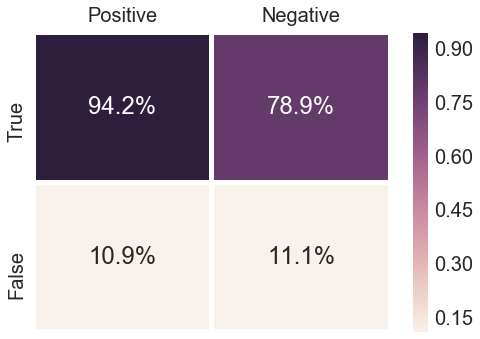

In [81]:
sns.set(font_scale=2)
fig, ax = plt.subplots()
sns.heatmap(conf_df, annot=True, fmt=".1%", linewidths=4, ax=ax)
ax.xaxis.tick_top()

Our classification model had 89% accuracy for the test dataset. From the confusion matrix above, we can see that the model identified 94.2% of all positive reviews in the test data correctly, and 78.9% of negative reviews correctly. 

In [109]:
pos_review = results_best.filter((results_best.prediction == 1.0) & (results_best.stars > 3)).\
    select("text", "stars").limit(5).toPandas()

In [110]:
neg_review = results_best.filter((results_best.prediction == 0.0) & (results_best.stars < 4)).\
    select("text", "stars").limit(5).toPandas()

Here's an example of a review classified as **positive**: 

In [111]:
pos_review.text[2]

"Matts feels like home. The tables remind me of snack time in Grandma's kitchen, the salt and pepper shakers remind me of the ones that sat on my neighbor's counter in her collections.... even the slightly wobbly leg of the chair reminds me of my college apartment furnished with family castaways and thrift shop treasures. \n\nREAL food comes from a place that feels so much like home... by real, i mean... real eggs, real butter, real sausage.... \n\nFood at Matt's is pure and innocent... Pancakes with butter. Eggs with potatoes and bacon. Classic. \n\nyum."

Here's an example of a review classified as **negative**:

In [112]:
neg_review.text[2]

"This place has received a lot of hype, so be prepared to wait.\nand wait.\nand wait.\n\nTo make the trip more enjoyable:\n- don't actually come hungry (or risk passing out in the lot from low-blood sugar)\n- show up at least hour earlier than you want to be seated then get on list\n- go hang out  at the farmers market across street while you wait\n- expect solid (but not mind blowing) food\n\nGo for the experience at least once, then find another breakfast spot."